# Analyzing Historical Plane Crash Data with Python

## Malori Hales

With recent media focus on aircraft types and their possible effect on flight safety, I thought that it would be beneficial to obtain and analyze plane crash data to see if there is a noticeable increase in plane crashes over time, or if there are any factors which contribute to plane crashes occuring. In this notebook, I explore, manipulate, and illustrate data containing all recorded plane crashes since 1908.

In [1]:
# importing libraries

import numpy as np 
import pandas as pd 
from collections import Counter
import re
import datetime as dt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Part 1: Obtaining the Data

I found this data on Kaggle.com. The dataset is titled "Historical Plane Crashes" and can be found [here](https://www.kaggle.com/nguyenhoc/plane-crash).

This csv file contains the known details about plane crashes that have occured over the last 100 years. The file has 5783 rows and 13 columns.

In [2]:
# reading the csv data file

data = pd.read_csv('planecrash.csv')

The variables included are: 

+ **date** : Date of accident, in the format Month DD, YYYY
+ **time** : Local time in 24hr format
+ **location** : Location information
+ **operator** : Airline or operator of the aircraft
+ **flight_no** : Flight number assigned by operator
+ **route** : Complete or partial route flown prior to accident
+ **ac_type** : Aircraft type
+ **registration** : ICAO registration of the aircraft
+ **cn_ln** : Construction or serial number
+ **aboard** : Total aboard, including passengers and crew
+ **fatalities** : Total fatalities aboard, including passengers and crew
+ **ground** : Total killed on the ground
+ **summary** : Brief description and cause of the accident, if known

In [3]:
# looking at the variable data types

data.dtypes

date            object
time            object
location        object
operator        object
flight_no       object
route           object
ac_type         object
registration    object
cn_ln           object
aboard          object
fatalities      object
ground          object
summary         object
dtype: object

**Here is the first five rows of the data:**

In [4]:
# viewing the first few rows of data in the dataframe

data.head()

,date,time,location,operator,flight_no,route,ac_type,registration,cn_ln,aboard,fatalities,ground,summary
0,"September 17, 1908",17:18,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2 (passengers:1 crew:1),1 (passengers:1 crew:0),0,"During a demonstration flight, a U.S. Army fly..."
1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1 (passengers:0 crew:1),1 (passengers:0 crew:0),0,Eugene Lefebvre was the first pilot to ever be...
2,"July 12, 1912",06:30,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5 (passengers:0 crew:5),5 (passengers:0 crew:5),0,First U.S. dirigible Akron exploded just offsh...
3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1 (passengers:0 crew:1),1 (passengers:0 crew:1),0,The first fatal airplane accident in Canada oc...
4,"September 09, 1913",c 18:30,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20 (passengers:? crew:?),14 (passengers:? crew:?),0,The airship flew into a thunderstorm and encou...


# Part 2: Scrubbing the Data

To scrub the data, I did the following:

+ dropped unused columns
+ replaced null values with more appropriate values
+ converted the dates to datetime objects
+ converted numerical values to integers
+ accessed and stored important values from dictionaries

In [3]:
# dropping columns I am not using

data = data.drop(columns=['location', 'flight_no', 'route', 'registration', 'cn_ln']) 

In [4]:
# converting the dates to datetime

date = []
for each in data.date:
    x = pd.to_datetime(each)
    date.append(x)
    
data.date = date

In [5]:
# accessing totals in dictionaries for fatalities and aboard

sepAboard = data.aboard.str.split()
aT,aP,aC = zip(*sepAboard) # total,passengers,crew for aboard
sepFatal = data.fatalities.str.split()
fT,fP,fC = zip(*sepFatal) # total,passengers,crew for fatalities
data.aboard = aT
data.fatalities = fT

In [6]:
# dropping null values in columns

data.dropna(inplace = True)
data.aboard.replace(['?'],0,inplace = True)
data.fatalities.replace(['?'],0,inplace = True)
data.ground.replace(['?'],0,inplace=True)
data.ac_type.replace(['?'],'unknown',inplace = True)

/var/folders/qf/sw8tcs0d1bscyfcr1dfkhg7w0000gn/T/ipykernel_59271/1058003104.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.aboard.replace(['?'],0,inplace = True)
/var/folders/qf/sw8tcs0d1bscyfcr1dfkhg7w0000gn/T/ipykernel_59271/1058003104.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [7]:
# converting totals to integer data types

data.aboard = data.aboard.astype(int)
data.fatalities = data.fatalities.astype(int)
data.ground = data.ground.astype(int)

In [10]:
# check the new datatype

data.dtypes

date          datetime64[ns]
time                  object
operator              object
ac_type               object
aboard                 int64
fatalities             int64
ground                 int64
summary               object
dtype: object

# Part 3 and 4: Exploring and Modeling the Data

For this portion of the project, I created some new columns of important information and calculated a few useful statistics of the data to be used in our models. Then I created plots to help visualize all of the statistics that I was interested in.

In [8]:
# creating a list of all the years in my data set

years = data.date.dt.year.unique()
years

array([1908, 1909, 1912, 1913, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int32)

In [9]:
# creating a column for year that is easier to work with than the full date

data['year'] = pd.DatetimeIndex(data['date']).year

In [10]:
# adding a count column to my dataframe to make counting easier

data['count'] = 1

In [11]:
# lets take a look at the new columns "year" and count"

data.head()

,date,time,operator,ac_type,aboard,fatalities,ground,summary,year,count
0,1908-09-17,17:18,Military - U.S. Army,Wright Flyer III,2,1,0,"During a demonstration flight, a U.S. Army fly...",1908,1
1,1909-09-07,?,?,Wright Byplane,1,1,0,Eugene Lefebvre was the first pilot to ever be...,1909,1
2,1912-07-12,06:30,Military - U.S. Navy,Dirigible,5,5,0,First U.S. dirigible Akron exploded just offsh...,1912,1
3,1913-08-06,?,Private,Curtiss seaplane,1,1,0,The first fatal airplane accident in Canada oc...,1913,1
4,1913-09-09,c 18:30,Military - German Navy,Zeppelin L-1 (airship),20,14,0,The airship flew into a thunderstorm and encou...,1913,1


**Below, I demonstrate how to access particular observations from the data frame.**

In [12]:
# locating the largest number of passengers involved in a single plane crash

data.loc[data['aboard'].idxmax()]

date                                        1977-03-27 00:00:00
time                                                      17:07
operator                       Pan American World Airways / KLM
ac_type                    Boeing B-747-121 / Boeing B-747-206B
aboard                                                      644
fatalities                                                  583
ground                                                        0
summary       Both aircraft were diverted to Tenerife becaus...
year                                                       1977
count                                                         1
Name: 3164, dtype: object

In [13]:
# locating the largest number of people killed on the ground by a single plane crash

data.loc[data['ground'].idxmax()]

date                                        2001-09-11 00:00:00
time                                                      09:03
operator                                       United Air Lines
ac_type                                        Boeing B-767-222
aboard                                                       65
fatalities                                                   65
ground                                                     2750
summary       The aircraft was hijacked shortly after it lef...
year                                                       2001
count                                                         1
Name: 5016, dtype: object

**Some of the crashes that were the most interesting to me were the four crashes that took place on September 11th, 2001. I decided to look at those crashes specifically, and compare the death counts of passengers on the plane to those who were killed on the ground.**

In [14]:
date911 = (data['date'] == '2001-09-11')

nine11 = data.loc[date911]
nine11

,date,time,operator,ac_type,aboard,fatalities,ground,summary,year,count
5016,2001-09-11,09:03,United Air Lines,Boeing B-767-222,65,65,2750,The aircraft was hijacked shortly after it lef...,2001,1
5017,2001-09-11,08:47,American Airlines,Boeing 767-223ER,92,92,2750,The aircraft was hijacked shortly after it lef...,2001,1
5018,2001-09-11,10:03,United Air Lines,Boeing B-757-222,44,44,0,The aircraft was hijacked after taking off fro...,2001,1
5019,2001-09-11,09:45,American Airlines,Boeing B-757-223,64,64,125,The aircraft was hijacked after taking off fro...,2001,1


In [15]:
nine11 = pd.DataFrame(nine11)

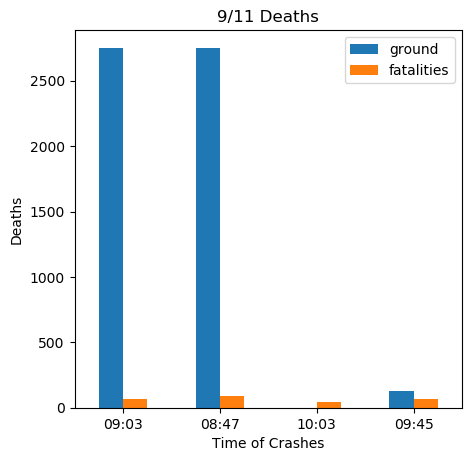

In [19]:
fig, ax = plt.subplots(1,1, figsize = (5,5), dpi = 100)
numRows = len(nine11) # gives us the number of rows
x = np.arange(numRows)

nine11[['ground','fatalities']].plot(kind = 'bar', ax=ax, rot=0) 
ax.set_xticks(x) 
ax.set_xticklabels(nine11['time']) 

ax.set_xlabel('Time of Crashes')
ax.set_ylabel('Deaths')

ax.set_title("9/11 Deaths")

ax.legend()

plt.show() 

### Interpretation:

**Above is a bar graph which shows the shocking number of people who died for each on of the four flights, and whether they were passengers onboard the aircraft or people killed on the ground as a result of the crash.**

## Analyzing Fatalities, Aboard, and Death Rate

In this section I work with the columns for aboard and fatalities, and create a new column called Death_Rate which contains the proportion of passengers who died in each crash.

In [20]:
data.head()

,date,time,operator,ac_type,aboard,fatalities,ground,summary,year,count
0,1908-09-17,17:18,Military - U.S. Army,Wright Flyer III,2,1,0,"During a demonstration flight, a U.S. Army fly...",1908,1
1,1909-09-07,?,?,Wright Byplane,1,1,0,Eugene Lefebvre was the first pilot to ever be...,1909,1
2,1912-07-12,06:30,Military - U.S. Navy,Dirigible,5,5,0,First U.S. dirigible Akron exploded just offsh...,1912,1
3,1913-08-06,?,Private,Curtiss seaplane,1,1,0,The first fatal airplane accident in Canada oc...,1913,1
4,1913-09-09,c 18:30,Military - German Navy,Zeppelin L-1 (airship),20,14,0,The airship flew into a thunderstorm and encou...,1913,1


**I created another new column, this one showing the rate of survival for each given plane crash.**

In [16]:
data['survival'] = 1-(data.fatalities/data.aboard)

In [17]:
data.survival.replace(['?'],0,inplace=True)

/var/folders/qf/sw8tcs0d1bscyfcr1dfkhg7w0000gn/T/ipykernel_59271/2268465729.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.survival.replace(['?'],0,inplace=True)


In [18]:
data.survival = data.survival.fillna(0)

In [19]:
data.survival = data.survival.astype(float)

In [25]:
data.head(10)

,date,time,operator,ac_type,aboard,fatalities,ground,summary,year,count,survival
0,1908-09-17,17:18,Military - U.S. Army,Wright Flyer III,2,1,0,"During a demonstration flight, a U.S. Army fly...",1908,1,0.500000
1,1909-09-07,?,?,Wright Byplane,1,1,0,Eugene Lefebvre was the first pilot to ever be...,1909,1,0.000000
2,1912-07-12,06:30,Military - U.S. Navy,Dirigible,5,5,0,First U.S. dirigible Akron exploded just offsh...,1912,1,0.000000
3,1913-08-06,?,Private,Curtiss seaplane,1,1,0,The first fatal airplane accident in Canada oc...,1913,1,0.000000
4,1913-09-09,c 18:30,Military - German Navy,Zeppelin L-1 (airship),20,14,0,The airship flew into a thunderstorm and encou...,1913,1,0.300000
5,1913-10-17,c 10:30,Military - German Navy,Zeppelin L-2 (airship),30,30,0,Hydrogen gas which was being vented was sucked...,1913,1,0.000000
6,1915-03-05,c 01:00,Military - German Navy,Zeppelin L-8 (airship),41,21,0,Crashed into trees while attempting to land af...,1915,1,0.487805
7,1915-09-03,c 15:20,Military - German Navy,Zeppelin L-10 (airship),19,19,0,"Exploded and burned near Neuwerk Island, when...",1915,1,0.000000
8,1916-07-28,?,Military - German Army,Schutte-Lanz S-L-10 (airship),20,20,0,"Crashed near the Black Sea, cause unknown.",1916,1,0.000000
9,1916-09-24,c 01:00,Military - German Navy,Zeppelin L-32 (airship),22,22,0,Shot down by British aircraft crashing in flames.,1916,1,0.000000


In [20]:
# average death rate for each year
## rerun cell if avg_survived contains infinite values

avg_survived = []
yr = years

for each in yr:
    x = np.mean(data.survival[data['year']==each])
    avg_survived.append(x)
    
print("Average death rate for each year: ", avg_survived)

Average death rate for each year:  [np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(0.10000000000000002), np.float64(0.24390243902439024), np.float64(0.00714285714285714), np.float64(0.017857142857142856), np.float64(0.0), np.float64(0.0), np.float64(0.1111111111111111), np.float64(0.0), np.float64(0.05726495726495727), np.float64(0.05416666666666667), np.float64(0.0), np.float64(0.0613107822410148), np.float64(0.12307692307692308), np.float64(0.09962121212121212), np.float64(0.1560185185185185), np.float64(0.16895682664913433), np.float64(0.15958624708624708), np.float64(0.09956709956709957), np.float64(0.09668367346938776), np.float64(0.11321532999164578), np.float64(0.1469047619047619), np.float64(-inf), np.float64(0.17421480054472382), np.float64(0.2475210497185538), np.float64(0.09348698543744985), np.float64(0.17859987234987232), np.float64(0.1161852036852037), np.float64(0.17463578088578088), np.float64(-inf), np.float64(0.06277628182764745), np.float64(0.085743289

In [21]:
survive_df = pd.DataFrame(avg_survived, columns=['Average'])
len(survive_df)

108

**The plot below shows how the average death rate for each year has changed over time.**

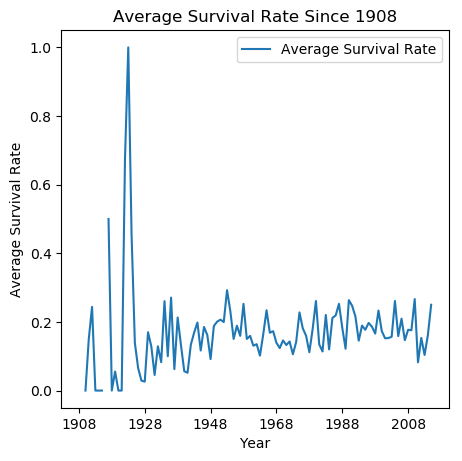

In [59]:
# average death rate over time

yearLabels = list(range(1908-20,2018+1, 20))
tickSpacing = 20

fig, ax = plt.subplots(1,1, figsize = (5,5), dpi = 100)
numRows = len(survive_df) 
x = np.arange(numRows)

ax.plot(x, survive_df['Average'], label = 'Average Survival Rate') 

ax.set_xticks(x) 
ax.set_xticklabels(yearLabels, rotation = 0) 

ax.xaxis.set_major_locator(ticker.MultipleLocator(tickSpacing))

ax.set_xlabel('Year')
ax.set_ylabel('Average Survival Rate')

ax.set_title("Average Survival Rate Since 1908")

ax.legend()

plt.show()

### Interpretation:

**In the graph above we see that there has been a slight decrease over time in the proportion of people who die in crashes.**

In [29]:
# total crashes for each year

sum_crashes = []

year = data.date.dt.year.unique()

for each in year:
    x = sum(data['count'][data.year==each])
    sum_crashes.append(x)
    
print("Total crashes for each year: ", sum_crashes)

Total crashes for each year:  [1, 1, 1, 3, 2, 5, 7, 4, 8, 18, 12, 13, 12, 7, 11, 13, 20, 36, 39, 26, 33, 28, 28, 30, 38, 46, 30, 57, 28, 22, 22, 37, 42, 54, 73, 88, 82, 76, 67, 69, 74, 65, 69, 62, 57, 53, 66, 68, 66, 71, 59, 77, 62, 69, 75, 76, 96, 97, 91, 91, 69, 105, 91, 86, 78, 88, 83, 78, 91, 66, 67, 70, 62, 65, 74, 64, 75, 83, 95, 71, 88, 86, 67, 87, 79, 81, 68, 69, 79, 77, 71, 75, 62, 61, 52, 51, 54, 63, 52, 48, 46, 29, 33, 33, 22, 24, 14, 18]


In [30]:
crashes_df = pd.DataFrame(sum_crashes, columns=['Total'])
len(crashes_df)

108

**In the following plot, I illustate the total number of plane crashes for each year since 1908.**

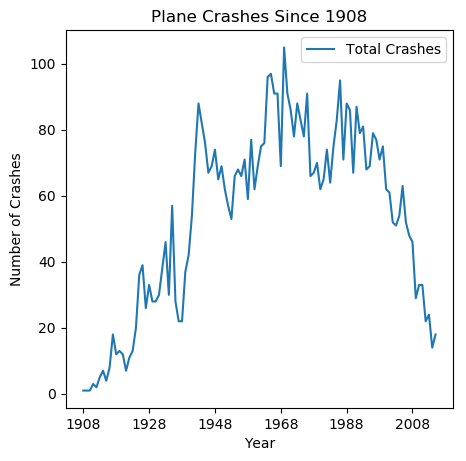

In [31]:
# plane crashes over time

yearLabels = list(range(1908-20,2018+1, 20))
tickSpacing = 20

fig, ax = plt.subplots(1,1, figsize = (5,5), dpi = 100)
numRows = len(crashes_df) 
x = np.arange(numRows)

ax.plot(x, crashes_df['Total'], label = 'Total Crashes') 

ax.set_xticks(x) 
ax.set_xticklabels(yearLabels, rotation = 0) 

ax.xaxis.set_major_locator(ticker.MultipleLocator(tickSpacing)) 

ax.set_xlabel('Year')
ax.set_ylabel('Number of Crashes')

ax.set_title("Plane Crashes Since 1908")

ax.legend()

plt.show()

### Interpretation:


**In the graph above, we see that the number of crashes each year has been steadily decreasing since the 1980's. There were the highest number of crashes between about 1940 and 1990.**

In [22]:
# looking at the total number of fatalities for each year

tot_F = data.groupby('year')['fatalities'].sum()
tot_F.head()

year
1908     1
1909     1
1912     5
1913    45
1915    40
Name: fatalities, dtype: int64

In [23]:
# creating lists of total fatalities per year and total aboard per year

sum_fatalities = []
sum_aboard = []

year = data.date.dt.year.unique()

for each in year:
    x = sum(data.fatalities[data.year==each])
    y = sum(data.aboard[data.year==each])
    sum_fatalities.append(x)
    sum_aboard.append(y)
    
print("Fatality sums for each year: ", sum_fatalities)
print()
print("Sum of passengers aboard planes that crashed each year: ", sum_aboard )

Fatality sums for each year:  [1, 1, 5, 45, 40, 108, 138, 65, 20, 25, 67, 89, 77, 20, 34, 37, 52, 113, 133, 147, 102, 75, 205, 129, 234, 252, 227, 467, 160, 213, 246, 506, 676, 689, 1365, 1327, 1306, 1254, 1163, 1438, 1245, 1274, 1302, 1005, 911, 1001, 1114, 1391, 1145, 1738, 1539, 2123, 1379, 1354, 1824, 1712, 1814, 2164, 2101, 2118, 1951, 2946, 2477, 2387, 1659, 2037, 2173, 1576, 1992, 1829, 1245, 1794, 1612, 1033, 2670, 1471, 1723, 2034, 2283, 1182, 1839, 2121, 1571, 1874, 1593, 2386, 1672, 1544, 971, 1469, 1416, 1433, 1279, 727, 1317, 1161, 931, 824, 1095, 1087, 764, 596, 341, 1189, 774, 519, 197, 853]

Sum of passengers aboard planes that crashed each year:  [2, 1, 5, 51, 60, 109, 140, 65, 20, 32, 67, 102, 80, 20, 63, 52, 69, 134, 178, 189, 121, 87, 231, 165, 283, 344, 361, 536, 214, 249, 298, 571, 738, 774, 1489, 1649, 1748, 1540, 1626, 1689, 1392, 1572, 1596, 1187, 1242, 1507, 1581, 1804, 1369, 2128, 2108, 2540, 1642, 1717, 2387, 2001, 2358, 2938, 2722, 2790, 2587, 3644, 3481, 3

In [24]:
# converting fatalities per year to dataframe and checking length

fatal_df = pd.DataFrame(sum_fatalities, columns=['Total'])
len(fatal_df)

108

In [25]:
# converting aboard per year to dataframe and checking length

aboard_df = pd.DataFrame(sum_aboard, columns=['Total'])
len(aboard_df)

108

**In the plot below, I calculate the total number of passengers onboard crashed aircrafts and compare it to the total number of passengers who died as a result of those crashes. The gap between the lines on the plot illustrates the number of survivors of plane crashes for each year.**

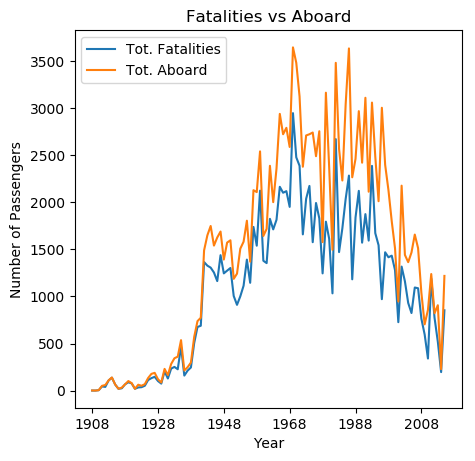

In [36]:
# plotting fatalities vs aboard over time

yearLabels = list(range(1908-20,2018+1, 20))
tickSpacing = 20

fig, ax = plt.subplots(1,1, figsize = (5,5), dpi = 100)
numRows = len(fatal_df) # gives us the number of rows
x = np.arange(numRows)

ax.plot(x, fatal_df['Total'], label = 'Tot. Fatalities') 
ax.plot(x, aboard_df['Total'], label = 'Tot. Aboard')

ax.set_xticks(x) 
ax.set_xticklabels(yearLabels, rotation = 0) 

ax.xaxis.set_major_locator(ticker.MultipleLocator(tickSpacing))

ax.set_xlabel('Year')
ax.set_ylabel('Number of Passengers')

ax.set_title("Fatalities vs Aboard")

ax.legend()

plt.show() # this line gets rid of the weird text above the graph

### Interpretation:

**With this graph we see that, while the number of crashes increased in the mid 90's, so did the number of *survivors*. The space between the lines for fatalities and total aboard makes it easy to see how many of the passengers involved in each crash were able to survive the incident.**

## Analyzing Operator and Aircraft Type

In this section, I look at specific operators and aircraft types, and make bar charts to illustrate which show up most frequently in the plane crash data set.

In [26]:
# counting how many unique operators are in the dataset

data['operator'].nunique()

2821

In [27]:
# getting the total amount of fatalities assosciated with each unique operator

data.groupby('operator')['fatalities'].sum()

operator
46826/109                          1
?                                161
A B Aerotransport                  3
A&C Big Sky Aviation               2
AB Aerotransport                  58
                                ... 
Zantop International Airlines      4
Zen Nippon                         2
de Havilland Aircraft              9
de Havilland Dove                  7
èkoda (India) Ltd                  3
Name: fatalities, Length: 2821, dtype: int64

In [28]:
# counting number of obervations for each operator
operatorCount = data.groupby('operator')['count'].sum()

# printing the top 10 operators involved in plane accidents
largestOper = operatorCount.nlargest(15)
largestOper

operator
Aeroflot                               260
Military - U.S. Air Force              177
Air France                              72
Deutsche Lufthansa                      64
United Air Lines                        44
China National Aviation Corporation     43
Military - U.S. Army Air Forces         43
Pan American World Airways              41
American Airlines                       37
Military - Royal Air Force              36
Military - U.S. Navy                    35
US Aerial Mail Service                  35
Indian Airlines                         34
KLM Royal Dutch Airlines                34
Private                                 34
Name: count, dtype: int64

**In this graph, I compare the top 15 most frequently appearing operators in the data set.**

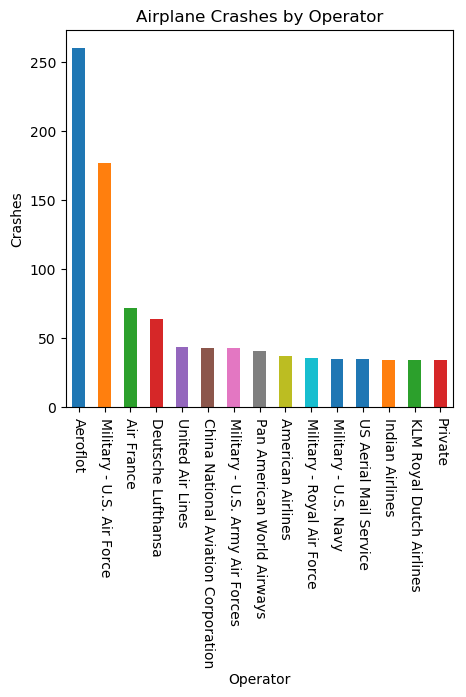

In [40]:
# plotting number of crashes for the top 15 operators

fig, ax = plt.subplots(1,1, figsize = (5,5), dpi = 100)
numRows = len(largestOper) 
x = np.arange(numRows)

largestOper.plot(kind='bar', rot=-90)

ax.set_xlabel('Operator')
ax.set_ylabel('Crashes')

ax.set_title("Airplane Crashes by Operator")

plt.show() 

### Interpretation:

**In the graph above, we see that various military flight operators account for a good amount of the recorded plane crashes. Air France, United Airlines, American Airlines, and Indian Airlines are well known commercial operators among the operators listed.**

In [41]:
# change each aircraft type to only specify the make of the aircraft

aircraft = []

for each in (data.ac_type.str.split()):
    aircraft.append( each[0])
    
data.ac_type = aircraft

In [42]:
(data.groupby('ac_type')['count'].sum()).idxmax()

'Douglas'

In [43]:
# counting number of obervations for each aircraft
aircraftCount = data.groupby('ac_type')['count'].sum()

# printing the top 10 operators involved in plane accidents
largestAC = aircraftCount.nlargest(15)
largestAC

ac_type
Douglas       1013
Boeing         407
Lockheed       362
Cessna         318
Antonov        289
de             279
Ilyushin       145
Fokker         139
Piper          138
Beechcraft     129
McDonnell      127
Curtiss        126
Tupolev        109
Vickers         95
Convair         89
Name: count, dtype: int64

**Next, I made a similar graph showing the aircrafts, by company, which were involved in the most accidents.**

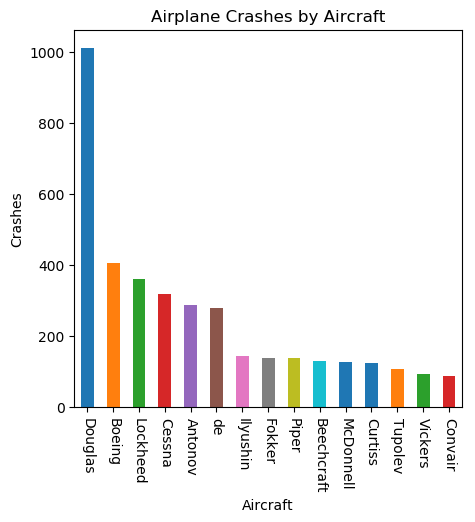

In [44]:
# plotting the number of crashes for the top 20 aircrafts

fig, ax = plt.subplots(1,1, figsize = (5,5), dpi = 100)
numRows = len(largestAC) 
x = np.arange(numRows)

largestAC.plot(kind='bar', rot=-90)

ax.set_xlabel('Aircraft')
ax.set_ylabel('Crashes')

ax.set_title("Airplane Crashes by Aircraft")

plt.show() 

### Interpretation:


**In the graph above, we see the companies which have aircrafts that are involved in the most aircraft crashes. We see that Douglas planes account for the majority of all planes involved in the accidents recorded.**

## Analyzing Time of Day

In order to work with the "time" column in this dataset, I first had to clean it up. Since different countries use different time formatting, and the people who compiled the original data were inconsistent, the column for time was very messy. Luckily, another Kaggle user took the time to write code which uses regular expressions to put the times in a more useable format. This author is Melikşah Gürcü, and his code can be found [here](https://www.kaggle.com/mackali/data-analyses-of-airplane-crashes/notebook). I give full credit to Gürcü for the code used in the cell below, and greatly appreciate his helpful contribution. 

In [45]:
data['time'].replace(['?'],'00:00',inplace = True)
time = []
for each in data.time:
    x = re.sub('[^0-9]','',each)
    x = re.sub(' ','',x)
    if len(x)!=4:
        x = '0000'
    a = list(x)
    a.insert(2,':')
    a = ''.join(a)
    time.append(a)
   
data['time'] = time

In [46]:
a = data[data.time == '00:00'].index
data.drop(a,inplace = True)

In [47]:
a = pd.to_datetime(data.time)

b = a.dt.hour.values

data['time'] = b

len(data)

3601

**Here, I have created a plot showing how the average number of fatalities is effected during each hour of the day.**

Text(0, 0.5, 'Fatalities')

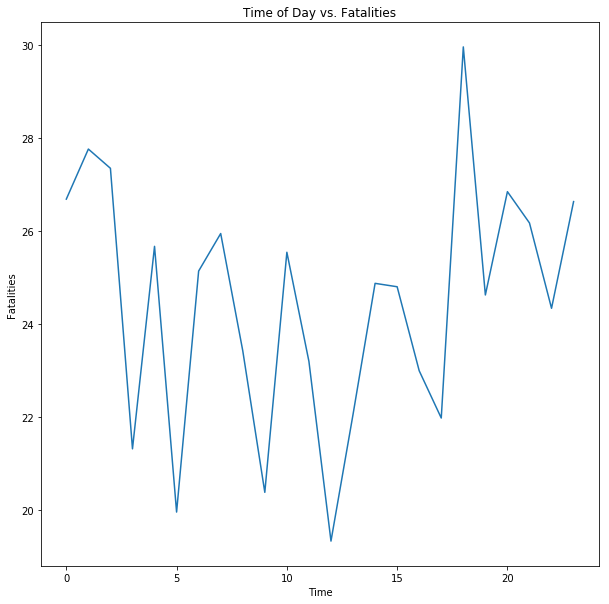

In [48]:
# looking at how fatalities are associated with time of day

plt.figure(figsize=(10,10))

data.groupby(data.time).fatalities.mean().plot()
plt.title('Time of Day vs. Fatalities')
plt.xlabel('Time')
plt.ylabel('Fatalities')

**I realized that a better model would involve comparing time of day and *death rate*, rather than fatalities. Here is a plot of the calculated avergage death rate compared to time of day.**

Text(0, 0.5, 'Survival Rate')

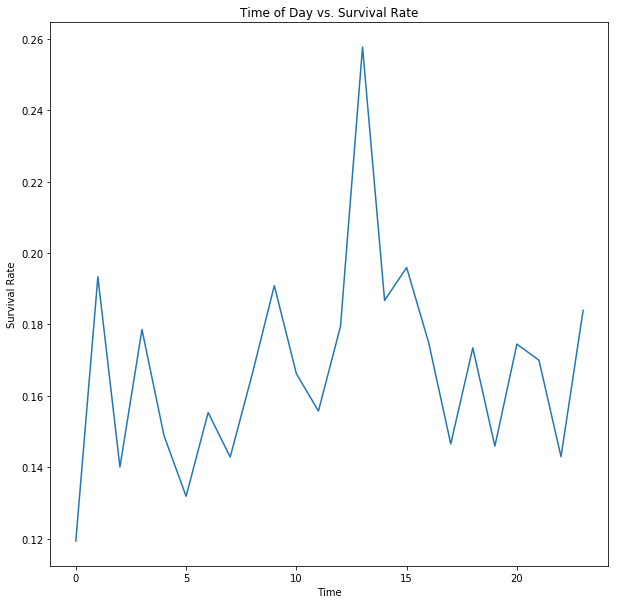

In [49]:
plt.figure(figsize=(10,10))

data.groupby(data.time).survival.mean().plot()
plt.title('Time of Day vs. Survival Rate')
plt.xlabel('Time')
plt.ylabel('Survival Rate')

### Interpretation:


**In the plot above we see that there does seem to be a noticeable decrease in the death rate (meaning an increase in survival) during the middle hours of the day. Perhaps this is due to more visibility, since we see that surviving is more likely when there is still daylight.**

## Anaylzing Word Frequencies in Crash Summaries

In this final section, I utilized the summary column in the data set and used it to look at the frequencies of specific words which show up in the plane crash description. For added visualization, and also for fun, I have created a word cloud for the most frequent words that appear in all of the crash summaries.

In [29]:
# concatenating all of the summary details

append_summary = []
x = data.summary
append_summary.append(x)

sumText = []
for row in data.summary:
    sumText.append(row)

blockText= ','.join(sumText) # turns all of the text into one long string
# blockText

In [30]:
# looking at specific word frequencies

# inclement weather 
for word in "storm, snow, rain, snowstorm, thunder, thunderstorm, lightning, weather, fog, low visibility".split(','):
    matches = re.findall("({})".format(word), blockText)
    print(word, len(matches))
print()
    
# malfunctions
for word in "malfunction, error, failure, engine failure, system, stalled, collision, take off, impact".split(','):
    matches = re.findall("({})".format(word), blockText)
    print(word, len(matches))
print()
    
# misc.
for word in "hijacked, fire, burned, terrorist, mountain, shot, exploded, explode, distress, disappeared".split(','):
    matches = re.findall("({})".format(word), blockText)
    print(word, len(matches))
print()

storm 318
 snow 174
 rain 268
 snowstorm 40
 thunder 166
 thunderstorm 162
 lightning 49
 weather 690
 fog 393
 low visibility 27

malfunction 54
 error 333
 failure 776
 engine failure 145
 system 178
 stalled 171
 collision 153
 take off 120
 impact 159

hijacked 20
 fire 551
 burned 190
 terrorist 8
 mountain 805
 shot 64
 exploded 101
 explode 106
 distress 20
 disappeared 55



### Interpretation:


**The words listed above with their frequencies were words that we selected by visually scanning through the crash summaries and selecting words that were of interest to me. I wanted to get an idea of what types of things most commonly influence or cause plane crashes to occur. For example, I saw in the crash summaries that the word "mountain" occured frequently, and thus decided it would be interesting to count the number of times that word appears in any of the crash descriptions in the data set. I found that the word occured in the data 549 times!**

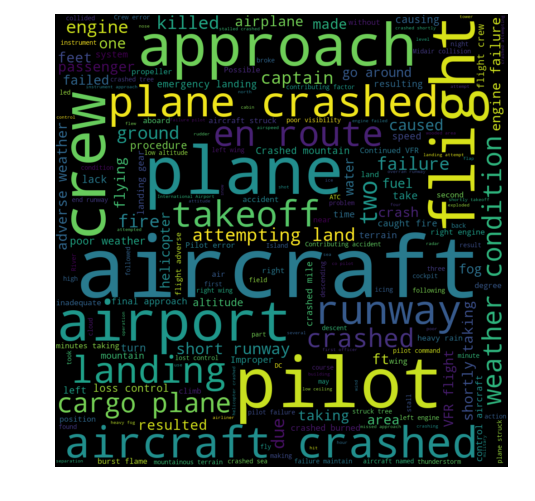

In [52]:
# wordcloud of most frequent words from crash detail summaries

wc = WordCloud(width = 1000, height=1000, margin=5).generate(blockText)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

### Interpretation:


**The wordcloud above provides a different way of visualizing word freqiencies in the plane crash summaries throughout the data set.**

# Conclusion:

In this project I was able to make several data visualizations which helped provide some insight on plane crashes that have occured in the last 100 years. According to the [Bureau of Transporation Statistics](https://www.bts.gov/), there were over 965 million passengers onboard domestic and international flights in 2017. A simple calculation for the probability of being on a plane that crashed in 2017 is shown below:

In [53]:
# dividing the number of passengers onboard for 2017 by the total number of passengers reported for that year

sum_aboard[-2]/965000000

2.3626943005181346e-07

We can see that for 2017, the probablility that a passenger would be involved in a crash for any given flight is 0.000000236 or **0.0000236%**.

To make another (very generous) predicition, we can estimate this probablity for the last 9 years by using the total number of passengers in 2010 (over 630 million according to [BTS](https://www.bts.gov/)). Below are the predicted probabilites of any passenger being involved on a plane crash for a given flight.

In [54]:
# calculating generous estimates for probability of being in a plane crash for the last 9 years

for i in range(1,10):
    prob = sum_aboard[-i]/630000000
    yr = 2019 - i
    print(yr, ":", prob)

2018 : 1.933333333333333e-06
2017 : 3.619047619047619e-07
2016 : 1.4396825396825396e-06
2015 : 1.3047619047619047e-06
2014 : 1.965079365079365e-06
2013 : 1.3603174603174603e-06
2012 : 1.1174603174603176e-06
2011 : 1.6507936507936508e-06
2010 : 2.4015873015873017e-06


With this estimate, it appears that the probablility that a passenger would be involved in a crash for any given flight over the last 9 years is *no more than* 0.0000024 or **0.00024%**. I believe these calculated probabilities are comforting since they show just how unlikely it is to be involved in a plane crash for a given flight. 

Not only did this project illustate how likely a given person is to be involved in a crash, I also found that most recorded plane crashes were military flights. Using the word frequency analysis, I found that the most common causes of recorded accidents are weather related, rather than aircraft or engine related. By analyzing time of day compared to fatalities and survival rate, we can see that less plane crashes occur during the day, and passengers that *are* involved in plane crashes during daytime hours have a higher chance of survival.

Over the last several decades, commerical flights have steadily increased while the likelihood of flight crashing has steadily decreased. Airline passengers appear to be more safe now than ever, especially when traveling with a trustworthy airline. Lastly, this project has greatly strengthed my knowledge and understanding in using pandas, numpy, and matplotlib when programming with Python.